<a href="https://colab.research.google.com/github/JoaoVitorSantiagoNogueira/deepLearning2023/blob/main/T1/Task1_DL.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##Fontes
[1] https://towardsdatascience.com/handwritten-digit-mnist-pytorch-977b5338e627

[2] https://www.kaggle.com/code/pankajj/fashion-mnist-with-pytorch-93-accuracy

[3] https://pytorch.org/vision/main/datasets.html

[4] https://saturncloud.io/blog/check-the-total-number-of-parameters-in-a-pytorch-model/#:~:text=To%20check%20the%20number%20of%20parameters%20in%20a%20PyTorch%20model,its%20total%20number%20of%20elements.

[5]https://saturncloud.io/blog/how-to-install-cuda-in-google-colab-gpus/

[6]https://stackoverflow.com/questions/12332975/how-can-i-install-a-python-module-within-code

##Exportar

In [ ]:
!pip install nbconvert
!jupyter nbconvert --to html /content/your_notebook.ipynb

[NbConvertApp] WARNING | pattern '/content/your_notebook.ipynb' matched no files
This application is used to convert notebook files (*.ipynb)
        to various other formats.


Options
The options below are convenience aliases to configurable class-options,
as listed in the "Equivalent to" description-line of the aliases.
To see all configurable class-options for some <cmd>, use:
    <cmd> --help-all

--debug
    set log level to logging.DEBUG (maximize logging output)
    Equivalent to: [--Application.log_level=10]
--show-config
    Show the application's configuration (human-readable format)
    Equivalent to: [--Application.show_config=True]
--show-config-json
    Show the application's configuration (json format)
    Equivalent to: [--Application.show_config_json=True]
--generate-config
    generate default config file
    Equivalent to: [--JupyterApp.generate_config=True]
-y
    Answer yes to any questions instead of prompting.
    Equivalent to: [--JupyterApp.answer_yes=True]
--

# Execcutar tudo

##Inicializar o Código

### Bibliotecas

In [ ]:
import numpy as np
import torch
import torchvision
import matplotlib.pyplot as plt
from time import time
from torchvision import datasets, transforms
from torch import nn, optim
from torch.utils.data import DataLoader, Dataset
from torch.autograd import Variable
import torch.nn.functional as F

###Redes

#### CNN
A estrutura proposta [2] utiliza as seguintes camadas:
  2 camadas convlucionais, que são uma sequência de Convoluções 2d, com o numero de canais respectivo, uma normalização 2d de batch, e ativação na forma de uma ReLU e MaxPooling 2d.

  Após isso, tem um "hack" para linearizar os dados, out.view(dimensão da matriz retustante, -1) força um display de tensor linear, que após isso vai passaar por 3 camadas "lineares" fully connected.

In [ ]:
class FashionCNN(nn.Module):
  def __init__(self):
    super(FashionCNN, self).__init__()

    self.layer1 = nn.Sequential(
        nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, padding=1),
        nn.BatchNorm2d(32),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2, stride=2)
    )

    self.layer2 = nn.Sequential(
        nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3),
        nn.BatchNorm2d(64),
        nn.ReLU(),
        nn.MaxPool2d(2)
    )

    self.fc1 = nn.Linear(in_features=64*6*6, out_features=600)
    self.drop = nn.Dropout2d(0.25)
    self.fc2 = nn.Linear(in_features=600, out_features=120)
    self.fc3 = nn.Linear(in_features=120, out_features=10)

  def forward(self, x):
    out = self.layer1(x)
    out = self.layer2(out)
    out = out.view(out.size(0), -1)
    out = self.fc1(out)
    out = self.drop(out)
    out = self.fc2(out)
    out = self.fc3(out)

    return out

[4] Vizualiza o número de parâmetros das redes para garantir que elas tem tamanhos semelhantes. Numero de parametros: 1.475338 * 10^7

In [ ]:
CNNmodel = FashionCNN()

total_params = sum(p.numel() for p in CNNmodel.parameters())
print(f"Number of parameters: {total_params}")

Number of parameters: 1475338


#### Fully connected
Tendo em mente o resultado esperdo pela rede CNN, podemos simular uma estrutura semelahnte, tentando preservar o nnúmero de parametros, substituindo as camadas convolucionáis por fullyconected (começando com tamanho 28x28).

Arquitetura própria

In [ ]:
class FashionFC(nn.Module):
  def __init__(self):
    super(FashionFC, self).__init__()

    self.fc1 = nn.Linear(in_features=28*28, out_features=600)
    self.drop = nn.Dropout2d(0.25)
    self.fc2 = nn.Linear(in_features=600, out_features=1200)
    self.fc3 = nn.Linear(in_features=1200, out_features=600)
    self.fc4 = nn.Linear(in_features=600, out_features=120)
    self.fc5 = nn.Linear(in_features=120, out_features=10)

  def forward(self, x):
    out = x.view(x.size(0), -1) #hack no começo para linearizar a imagem
    out = self.fc1(out)
    out = self.drop(out)
    out = F.relu(out)
    out = self.fc2(out)
    out = F.relu(out)
    out = self.fc3(out)
    out = self.drop(out)
    out = F.relu(out)
    out = self.fc4(out)
    out = F.relu(out)
    out = self.fc5(out)

    return out

Número de parametros: 1.986130x10^7

In [ ]:
FCmodel = FashionFC()

total_params = sum(p.numel() for p in FCmodel.parameters())
print(f"Number of parameters: {total_params}")

Number of parameters: 1986130


### DATASET

#### Download

In [ ]:
#função que recebe uma lista de operadores, ToTensor transforma em a imagem em um tensor, normaliza ela pra ter média e desvio padrão 0.5. Podia ser qualquer valor
#transform = transforms.Compose([transforms.ToTensor(),
#                              transforms.Normalize((0.5,), (0.5,)),
#                              ])

transform = transforms.Compose([transforms.ToTensor(),
                              ])

In [ ]:
# get datasets from torch
train_set = torchvision.datasets.FashionMNIST("./data", download=True, train=True, transform=transform)
test_set = torchvision.datasets.FashionMNIST("./data", download=True, train=False, transform=transform)

batchSize = 100

train_loader = torch.utils.data.DataLoader(train_set, batch_size=batchSize)
test_loader  = torch.utils.data.DataLoader(test_set , batch_size=batchSize)


#### Pré processamento

## Vizualização dos dados

In [ ]:
def output_label(label):
    output_mapping = {
                 0: "T-shirt/Top",
                 1: "Trouser",
                 2: "Pullover",
                 3: "Dress",
                 4: "Coat",
                 5: "Sandal",
                 6: "Shirt",
                 7: "Sneaker",
                 8: "Bag",
                 9: "Ankle Boot"
                 }
    input = (label.item() if type(label) == torch.Tensor else label)
    return output_mapping[input]

In [ ]:
a = next(iter(train_loader))
a[0].size()

torch.Size([100, 1, 28, 28])

In [ ]:
len(train_set)

60000

9


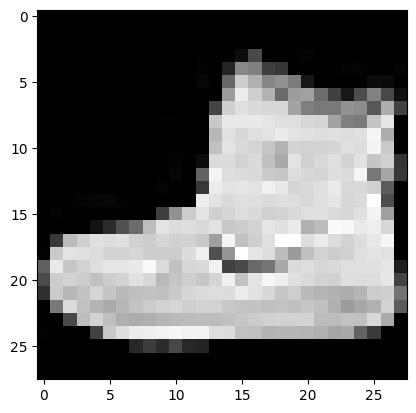

In [ ]:
image, label = next(iter(train_set))
plt.imshow(image.squeeze(), cmap="gray")
print(label)

<class 'torch.Tensor'> <class 'torch.Tensor'>
torch.Size([10, 1, 28, 28]) torch.Size([10])
labels:  Ankle Boot, T-shirt/Top, T-shirt/Top, Dress, T-shirt/Top, Pullover, Sneaker, Pullover, Sandal, Sandal, 

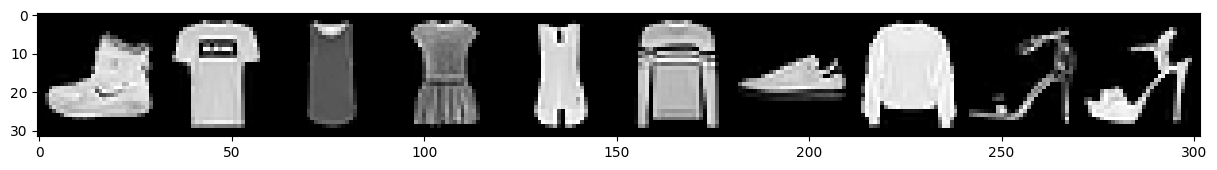

In [ ]:
demo_loader = torch.utils.data.DataLoader(train_set, batch_size=10)

batch = next(iter(demo_loader))
images, labels = batch
print(type(images), type(labels))
print(images.shape, labels.shape)

grid = torchvision.utils.make_grid(images, nrow=10)

plt.figure(figsize=(15, 20))
plt.imshow(np.transpose(grid, (1, 2, 0)))
print("labels: ", end=" ")
for i, label in enumerate(labels):
    print(output_label(label), end=", ")

## GPU
[5][6]temos/queremos tirar vantagem da GPU do google para acelerar o treinamento, logo temos que habilitar essas funcionalidades

In [ ]:
print(torch.cuda.is_available())
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

True


## Execução

### Definir Modelos

#### parametros comuns
Estamos abstraindo várias caracteristicas, como learning rate e escolha de otimizador para simplificar o projeto final e manter igual para ambos os modelos. Eventualmente um otimizador, erro ou learning rate vai beneficiar um modelo ou outro, mas é um risco que estamos dispostos a correr

In [ ]:
error = nn.CrossEntropyLoss()

learning_rate = 0.001

#### Específicos

CNN

In [ ]:
modelCNN = FashionCNN()
modelCNN.to(device)

optimizerCNN = torch.optim.Adam(modelCNN.parameters(), lr=learning_rate)
print(modelCNN)

FashionCNN(
  (layer1): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc1): Linear(in_features=2304, out_features=600, bias=True)
  (drop): Dropout2d(p=0.25, inplace=False)
  (fc2): Linear(in_features=600, out_features=120, bias=True)
  (fc3): Linear(in_features=120, out_features=10, bias=True)
)


FC

In [ ]:
modelFC = FashionFC()
modelFC.to(device)

optimizerFC = torch.optim.Adam(modelFC.parameters(), lr=learning_rate)
print(modelFC)

FashionFC(
  (fc1): Linear(in_features=784, out_features=600, bias=True)
  (drop): Dropout2d(p=0.25, inplace=False)
  (fc2): Linear(in_features=600, out_features=1200, bias=True)
  (fc3): Linear(in_features=1200, out_features=600, bias=True)
  (fc4): Linear(in_features=600, out_features=120, bias=True)
  (fc5): Linear(in_features=120, out_features=10, bias=True)
)


### Treinamento

####Setup

In [ ]:
def trainModel(model, optimizer, num_epochs):
  count = 0
  # Lists for visualization of loss and accuracy
  loss_list = []
  iteration_list = []
  accuracy_list = []

  # Lists for knowing classwise accuracy
  predictions_list = []
  labels_list = []
  for epoch in range(num_epochs):
      for images, labels in train_loader:
          # Transfering images and labels to GPU if available
          images, labels = images.to(device), labels.to(device)

          train = Variable(images.view(100, 1, 28, 28))
          labels = Variable(labels)

          # Forward pass
          outputs = model(train)
          loss = error(outputs, labels)

          # Initializing a gradient as 0 so there is no mixing of gradient among the batches
          optimizer.zero_grad()

          #Propagating the error backward
          loss.backward()

          # Optimizing the parameters
          optimizer.step()

          count += 1

      # Testing the model

          if not (count % 50):    # It's same as "if count % 50 == 0"
              total = 0
              correct = 0

              for images, labels in test_loader:
                  images, labels = images.to(device), labels.to(device)
                  labels_list.append(labels)

                  test = Variable(images.view(100, 1, 28, 28))

                  outputs = model(test)

                  predictions = torch.max(outputs, 1)[1].to(device)
                  predictions_list.append(predictions)
                  correct += (predictions == labels).sum()

                  total += len(labels)

              accuracy = correct * 100 / total
              loss_list.append(loss.data)
              iteration_list.append(count)
              accuracy_list.append(accuracy)

          if not (count % 500):
              print("Iteration: {}, Loss: {}, Accuracy: {}%".format(count, loss.data, accuracy))
  return iteration_list, loss_list, accuracy_list, predictions_list, labels_list

#### Training

In [ ]:
iteration_list_CNN, loss_list_CNN, accuracy_list_CNN, predictions_list_CNN, labels_list = trainModel(modelCNN, optimizerCNN, 5)
loss_list_CNN = [i.cpu().numpy() for i in loss_list_CNN]
accuracy_list_CNN = [i.cpu().numpy() for i in accuracy_list_CNN]

Iteration: 500, Loss: 0.5143749713897705, Accuracy: 87.36000061035156%
Iteration: 1000, Loss: 0.25424012541770935, Accuracy: 87.72000122070312%
Iteration: 1500, Loss: 0.3105819821357727, Accuracy: 88.36000061035156%
Iteration: 2000, Loss: 0.20607279241085052, Accuracy: 88.91999816894531%
Iteration: 2500, Loss: 0.14208915829658508, Accuracy: 90.04000091552734%
Iteration: 3000, Loss: 0.18538497388362885, Accuracy: 90.45999908447266%


In [ ]:
iteration_list_FC, loss_list_FC, accuracy_list_FC, predictions_list_FC, labels_list = trainModel(modelFC, optimizerFC, 5)
loss_list_FC= [i.cpu().numpy() for i in loss_list_FC]
accuracy_list_FC = [i.cpu().numpy() for i in accuracy_list_FC]

Iteration: 500, Loss: 0.5838962197303772, Accuracy: 82.11000061035156%
Iteration: 1000, Loss: 0.5014526844024658, Accuracy: 84.86000061035156%
Iteration: 1500, Loss: 0.43641796708106995, Accuracy: 83.93999481201172%
Iteration: 2000, Loss: 0.4362982511520386, Accuracy: 85.65999603271484%
Iteration: 2500, Loss: 0.3074561357498169, Accuracy: 85.1199951171875%
Iteration: 3000, Loss: 0.3215397298336029, Accuracy: 86.1500015258789%


### Vizualização

In [ ]:
def plotLoss(iter, loss1, loss2):
  plt.plot(iter, loss1, label = "CNN")
  plt.plot(iter, loss2, label = "FC")
  plt.xlabel("No. of Iteration: ")
  plt.ylabel("Loss")
  plt.title("Iterations vs Loss")
  plt.legend()
  plt.show()

In [ ]:
def plotAcc(iter, acc1, acc2):
  plt.plot(iter, acc1, label = "CNN" )
  plt.plot(iter, acc2, label = "FC")
  plt.xlabel("No. of Iteration")
  plt.ylabel("Accuracy")
  plt.title("Iterations vs Accuracy")
  plt.legend()
  plt.show()

In [ ]:
def test_model(model):
  class_correct = [0. for _ in range(10)]
  total_correct = [0. for _ in range(10)]

  with torch.no_grad():
      for images, labels in test_loader:
          images, labels = images.to(device), labels.to(device)
          test = Variable(images)
          outputs = model(test)
          predicted = torch.max(outputs, 1)[1]
          c = (predicted == labels).squeeze()

          for i in range(100):
              label = labels[i]
              class_correct[label] += c[i].item()
              total_correct[label] += 1

  for i in range(10):
      print("Accuracy of {}: {:.2f}%".format(output_label(i), class_correct[i] * 100 / total_correct[i]))

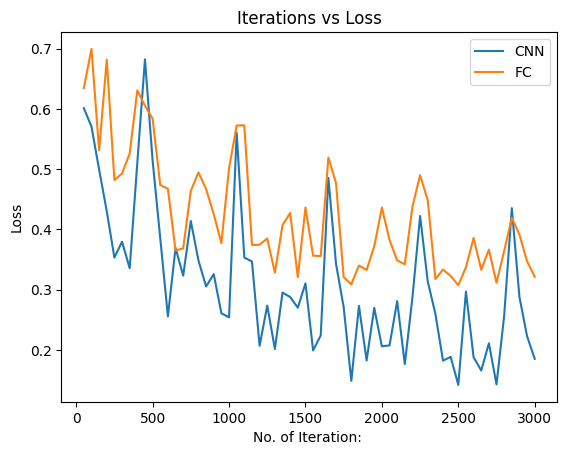

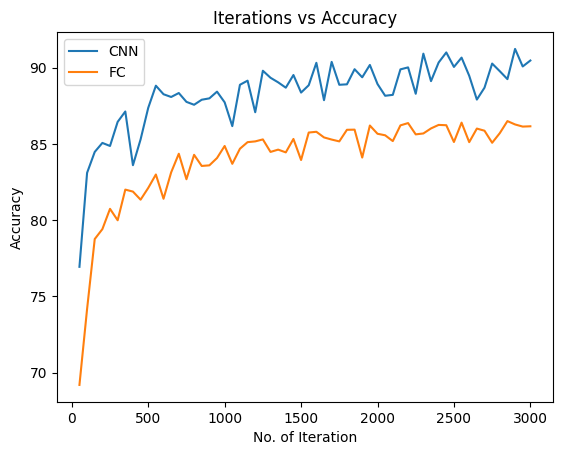

In [ ]:
plotLoss(iteration_list_CNN, loss_list_CNN, loss_list_FC)
plotAcc (iteration_list_CNN, accuracy_list_CNN, accuracy_list_FC)

In [ ]:
test_model(modelCNN)
print ("")
test_model(modelFC)

Accuracy of T-shirt/Top: 88.00%
Accuracy of Trouser: 98.70%
Accuracy of Pullover: 82.70%
Accuracy of Dress: 93.10%
Accuracy of Coat: 81.00%
Accuracy of Sandal: 95.70%
Accuracy of Shirt: 71.90%
Accuracy of Sneaker: 96.40%
Accuracy of Bag: 99.50%
Accuracy of Ankle Boot: 96.80%

Accuracy of T-shirt/Top: 91.90%
Accuracy of Trouser: 94.90%
Accuracy of Pullover: 75.10%
Accuracy of Dress: 88.00%
Accuracy of Coat: 82.40%
Accuracy of Sandal: 94.50%
Accuracy of Shirt: 49.80%
Accuracy of Sneaker: 95.60%
Accuracy of Bag: 97.20%
Accuracy of Ankle Boot: 94.60%


In [ ]:
def ConfussionMatrix(predictions_list,labels_list):
  from itertools import chain

  predictions_l = [predictions_list[i].tolist() for i in range(len(predictions_list))]
  labels_l = [labels_list[i].tolist() for i in range(len(labels_list))]
  predictions_l = list(chain.from_iterable(predictions_l))
  labels_l = list(chain.from_iterable(labels_l))

  import sklearn.metrics as metrics
  from sklearn.metrics import confusion_matrix

  confusion_matrix(labels_l, predictions_l)
  print("Classification report for CNN :\n%s\n"
        % (metrics.classification_report(labels_l, predictions_l)))

In [ ]:
ConfussionMatrix(predictions_list_CNN, labels_list)
ConfussionMatrix(predictions_list_FC, labels_list)

Classification report for CNN :
              precision    recall  f1-score   support

           0       0.83      0.82      0.83     60000
           1       0.97      0.98      0.98     60000
           2       0.85      0.82      0.83     60000
           3       0.87      0.89      0.88     60000
           4       0.80      0.83      0.81     60000
           5       0.97      0.96      0.97     60000
           6       0.69      0.67      0.68     60000
           7       0.93      0.94      0.93     60000
           8       0.96      0.97      0.97     60000
           9       0.95      0.95      0.95     60000

    accuracy                           0.88    600000
   macro avg       0.88      0.88      0.88    600000
weighted avg       0.88      0.88      0.88    600000


Classification report for CNN :
              precision    recall  f1-score   support

           0       0.80      0.79      0.79     60000
           1       0.98      0.96      0.97     60000
           2 